In [1]:
from itertools import combinations
import numpy as np
from z3 import *
import utils

In [2]:
WIDTH = 0
HEIGHT = 1

In [3]:
def at_least_one_np(bool_vars):
    return Or(bool_vars)

def at_most_one_np(bool_vars, name = ""):
    return [Not(And(pair[0], pair[1])) for pair in combinations(bool_vars, 2)]

def exactly_one_np(bool_vars, name = ""):
    return And(at_least_one_np(bool_vars), And(at_most_one_np(bool_vars, name)))

In [4]:
def at_least_one_seq(bool_vars):
    return at_least_one_np(bool_vars)

def at_most_one_seq(bool_vars, name):
    constraints = []
    n = len(bool_vars)
    s = [Bool(f"s_{name}_{i}") for i in range(n - 1)] # Need the s to have unique names
    constraints.append(Or(Not(bool_vars[0]), s[0]))
    constraints.append(Or(Not(bool_vars[n-1]), Not(s[n-2])))

    for i in range(1, n-1):
        constraints.append(Or(Not(bool_vars[i]), s[i]))
        constraints.append(Or(Not(s[i - 1]), s[i]))
        constraints.append(Or(Not(bool_vars[i]), Not(s[i - 1])))
    
    return And(constraints)

def exactly_one_seq(bool_vars, name):
    return And(at_most_one_seq(bool_vars, name), at_least_one_seq(bool_vars))

In [5]:
def at_least_k_seq(bool_vars, k, name):
    return at_most_k_seq([Not(var) for var in bool_vars], len(bool_vars)-k, name)

def at_most_k_seq(bool_vars, k, name):
    constraints = []
    n = len(bool_vars)
    s = [[Bool(f"s_{name}_{i}_{j}") for j in range(k)] for i in range(n - 1)]
    constraints.append(Or(Not(bool_vars[0]), s[0][0]))
    constraints += [Not(s[0][j]) for j in range(1, k)]
    for i in range(1, n-1):
        constraints.append(Or(Not(bool_vars[i]), s[i][0]))
        constraints.append(Or(Not(s[i-1][0]), s[i][0]))
        constraints.append(Or(Not(bool_vars[i]), Not(s[i-1][k-1])))
        for j in range(1, k):
            constraints.append(Or(Not(bool_vars[i]), Not(s[i-1][j-1]), s[i][j]))
            constraints.append(Or(Not(s[i-1][j]), s[i][j]))
    constraints.append(Or(Not(bool_vars[n-1]), Not(s[n-2][k-1])))   
    return And(constraints)

def exactly_k_seq(bool_vars, k, name):
    # The s list in at_most_k_seq must have unique names, so when we use it in at_least_k_seq it 
    # has to have a diffrent name from when we use it in at_most_k_seq. Hence name+"2"
    return And(at_most_k_seq(bool_vars, k, name), at_least_k_seq(bool_vars, k, name+"2"))

In [6]:
def coherent_cicuits(bool_vars, dims, n, w, upper_bound):
    print("HALLA")
    constraints = []
    for c in range(n):
        c_constraints = []
        height = dims[c][1]
        width = dims[c][0]
        for x in range(w-(dims[c][0]-1)):
            for y in range(upper_bound-(dims[c][1]-1)):
                temp = [bool_vars[x+i][y+j][c] for i in range(0, width) for j in range(0, height)]
                print(width, height)
                print("TEMP", temp)
                # cons = Or(Not(bool_vars[x][y][c]), And(temp))
                c_constraints.append(And(temp))
        constraints.append(Or(c_constraints))        
    return And(constraints)



In [7]:
def vlsi_design(w, n, dims):
    s = Solver()
    upper_bound = sum(dims[:, 1])
    print("Upper bound:", upper_bound)

    # Model the problem
    v = [[[Bool(f"v_{x}_{y}_{c}") for c in range(n)] for y in range(upper_bound)] for x in range(w)]
    
    # At most one circuit in each grid cell
    for x in range(w):
        for y in range(upper_bound):
            predicate = v[x][y]
            # print(predicate)
            s.add(at_most_one_seq(predicate, f"valid_cell_{x}_{y}"))
    
    # All the circuits must be placed in the grid
    for c in range(n):
        circuit_area = dims[c, WIDTH] * dims[c, HEIGHT]
        print(circuit_area, c+1)
        predicate = [v[x][y][c] for x in range(w) for y in range(upper_bound)]
        s.add(exactly_k_seq(predicate, circuit_area, f"valid_placement_{c}"))
    
    s.add(coherent_cicuits(v, dims, n, w, upper_bound))
    
    if s.check() == sat:
        model = s.model()
        sol = []
        for x in range(w):
            sol.append([])
            for y in range(upper_bound):
                found_circuit = False
                for c in range(n):
                    if model.evaluate(v[x][y][c]):
                        found_circuit = True
                        sol[x].append(c+1)
                if not found_circuit:
                    sol[x].append(0)

        return sol
    else:
        print("Buhu")

Upper bound: 16
9 1
15 2
15 3
25 4
HALLA
3 3
TEMP [v_0_0_0, v_0_1_0, v_0_2_0, v_1_0_0, v_1_1_0, v_1_2_0, v_2_0_0, v_2_1_0, v_2_2_0]
3 3
TEMP [v_0_1_0, v_0_2_0, v_0_3_0, v_1_1_0, v_1_2_0, v_1_3_0, v_2_1_0, v_2_2_0, v_2_3_0]
3 3
TEMP [v_0_2_0, v_0_3_0, v_0_4_0, v_1_2_0, v_1_3_0, v_1_4_0, v_2_2_0, v_2_3_0, v_2_4_0]
3 3
TEMP [v_0_3_0, v_0_4_0, v_0_5_0, v_1_3_0, v_1_4_0, v_1_5_0, v_2_3_0, v_2_4_0, v_2_5_0]
3 3
TEMP [v_0_4_0, v_0_5_0, v_0_6_0, v_1_4_0, v_1_5_0, v_1_6_0, v_2_4_0, v_2_5_0, v_2_6_0]
3 3
TEMP [v_0_5_0, v_0_6_0, v_0_7_0, v_1_5_0, v_1_6_0, v_1_7_0, v_2_5_0, v_2_6_0, v_2_7_0]
3 3
TEMP [v_0_6_0, v_0_7_0, v_0_8_0, v_1_6_0, v_1_7_0, v_1_8_0, v_2_6_0, v_2_7_0, v_2_8_0]
3 3
TEMP [v_0_7_0, v_0_8_0, v_0_9_0, v_1_7_0, v_1_8_0, v_1_9_0, v_2_7_0, v_2_8_0, v_2_9_0]
3 3
TEMP [v_0_8_0, v_0_9_0, v_0_10_0, v_1_8_0, v_1_9_0, v_1_10_0, v_2_8_0, v_2_9_0, v_2_10_0]
3 3
TEMP [v_0_9_0, v_0_10_0, v_0_11_0, v_1_9_0, v_1_10_0, v_1_11_0, v_2_9_0, v_2_10_0, v_2_11_0]
3 3
TEMP [v_0_10_0, v_0_11_0, v_0_12_0, 

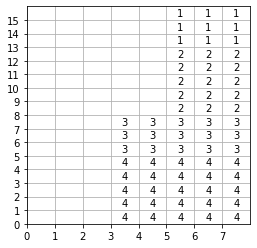

In [8]:
w = 8
n = 4
dims = np.array([[3, 3], [3, 5], [5, 3], [5, 5]])

sol = vlsi_design(w, n, dims)
len(sol)
utils.display_sudoku(sol, w, len(sol[0]))

In [22]:
sol

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 3],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 3, 1],
 [3, 0, 0, 0, 0, 4, 0, 3, 0, 4, 4, 4, 4, 4, 1, 2],
 [0, 0, 4, 0, 0, 0, 4, 4, 4, 3, 3, 3, 3, 3, 3, 2],
 [4, 4, 2, 4, 4, 1, 1, 2, 4, 1, 2, 2, 3, 3, 2, 3],
 [4, 4, 4, 2, 4, 4, 2, 4, 1, 4, 4, 4, 1, 3, 4, 1]]

In [27]:
en = 0
to =0
tre = 0 
fire = 0

for elm in sol:
    en += elm.count(1)
    to += elm.count(2)
    tre += elm.count(3)
    fire += elm.count(4)

print(en, to, tre, fire)
    

9 15 15 25
